#### using transfer learning for the segementation job

In [1]:
import torch

print(torch.cuda.is_available())

/home/li52/.conda/envs/LM/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [2]:
import tensorflow as tf

print(tf.__version__)

2.6.2


In [3]:
print(tf.__file__)

/home/li52/.conda/envs/LM/lib/python3.7/site-packages/tensorflow/__init__.py


In [4]:
# check the status of GPU
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()

[print(x) for x in local_device_protos if x.device_type == 'GPU']


name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31679774720
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17227565532124833321
physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0"



2022-06-20 09:36:53.087444: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-20 09:37:21.641097: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30212 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


[None]

define the neptune for documenting

In [5]:
# define if the documenting process should go on

DOCUMENT = True
TRAIN = 300 # training epochs num

In [6]:
# neptune document

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

if DOCUMENT:

    run = neptune.init(
        project="leeleeroy/LM-2D-Unet",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
        name = "UNet2D_64_vgg16",
    ) # necessary credentials, the name could be used to reproduce the results 

    # for callbacks in training



    neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')  # neptune for the training process
    
    # neptune document the hyper param.

    PARAMS = {
              "optimizer": {"learning_rate": 0.001, "beta_1":0.9,"optimizer": "Adam"},
              'epochs': TRAIN,
              'batch_size':8}

    # log hyper-parameters
    run['hyper-parameters'] = PARAMS
    run["sys/tags"].add(["transfer", "vgg16", "val", "binary", "epochs:300"])


/home/li52/.conda/envs/LM/lib/python3.7/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")
/home/li52/.conda/envs/LM/lib/python3.7/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


https://app.neptune.ai/leeleeroy/LM-2D-Unet/e/LMDUN-23
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [1]:
# data loading 

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os
import pandas as pd
import random

#### Load data in

In [2]:
# visualization for two images

def subShow(IMG1, IMG2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()

In [4]:
PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_partial_15/'

Mask = np.load(PATH + 'biMasks15.npy')
IMG = np.load(PATH + 'rawGray15.npy')

Mask = Mask.reshape(-1, 1040, 1392)  # flatten into images 
IMG = IMG.reshape(-1, 1040, 1392)
print('before:', Mask.shape)

Mask = Mask[...,176:(176+Mask.shape[1])]  # crop for later scaling
IMG = IMG[...,176:(176+IMG.shape[1])]

print('Mask info: ', Mask.shape, Mask.dtype)
print('Image info: ', IMG.shape, IMG.dtype)

before: (300, 1040, 1392)
Mask info:  (300, 1040, 1040) uint8
Image info:  (300, 1040, 1040) uint8


In [5]:
print(np.max(Mask[0,...]))

1


In [6]:
# resize the images

from skimage.transform import resize

SIZE = [256, 256]
totalIMG = Mask.shape[0]
numIMG = 250

smallIMG = resize(IMG[:numIMG,...], (numIMG,SIZE[0],SIZE[1]), anti_aliasing=True)
smallIMG = np.interp(smallIMG, (smallIMG.min(), smallIMG.max()), (0, 1))  # rescale the img

smallMask = resize(Mask[:numIMG,...].astype(bool), (numIMG,SIZE[0],SIZE[1]), anti_aliasing=False)
smallMask = smallMask.astype(int)

(250, 256, 256)


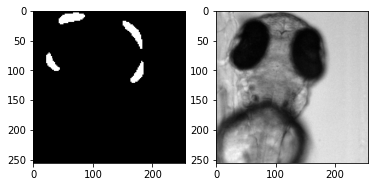

In [9]:
# sanity check

print(smallMask.shape)

NUM = 100

subShow(smallMask[NUM,...], smallIMG[NUM,...])

In [10]:
# patchify the images
from patchify import patchify, unpatchify

def rawPatch(imageStack,patchPara):
    all_img_patches = []

    for img in range(imageStack.shape[0]):
        large_image = imageStack[img]

        patches_img = patchify(large_image, (patchPara['x'],patchPara['y']), step=patchPara['step'])  # no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                # transform the image if the type is not correct
                if single_patch_img.dtype == 'uint8':
                    single_patch_img = (single_patch_img.astype('float32')) / 255.  # remember to standarize into 0-1
                    
                all_img_patches.append(single_patch_img)
    
    return all_img_patches, patches_img.shape

In [11]:
# # due to the huge data amount, use part of the images for the training 
# from skimage.transform import resize

# size = [256*(IMG.shape[1]//256), 256*(IMG.shape[2]//256)]

# numIMG = 25
# smallIMG = resize(IMG[:numIMG,...], (numIMG,size[0],size[1]), anti_aliasing=True)
# smallMask = resize(Mask[:numIMG,...], (numIMG,size[0],size[1]), anti_aliasing=True)

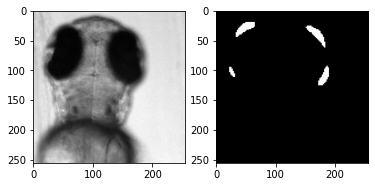

img: (250, 256, 256) float64
mask: (250, 256, 256) int64
img range: 1.0 0.0
mask range: 1 0


In [12]:
# sanity check for the resized data

subShow(smallIMG[0,...], smallMask[0,...])

print('img:',smallIMG.shape, smallIMG.dtype)
print('mask:',smallMask.shape, smallMask.dtype)

print('img range:', np.max(smallIMG), np.min(smallIMG))
print('mask range:', np.max(smallMask), np.min(smallMask))

In [13]:
# preporcessing the data into patches

# train dataset
patchPara = {'x': 256, 'y': 256, 'step':256}

X_patches, _ =  rawPatch(smallIMG, patchPara); X_patches = np.stack((X_patches,)*3, axis=-1)
Y_masks, _ = rawPatch(smallMask, patchPara); Y_masks = np.expand_dims(Y_masks, -1)


In [14]:
# # 测试单张图片上的衬度

# testOriginal = smallIMG[0,...]
# test = X_patches[0,:,:,0]

# test1 = np.equal(testOriginal, test)
# print(test1)

# print(np.min(test), np.min(testOriginal))

# print('img range:', np.max(smallIMG), np.min(smallIMG))
# print('img range:', np.max(X_patches), np.min(X_patches))

In [15]:
print('patches shape:',X_patches.shape, X_patches.dtype)
print('mask shape:',Y_masks.shape, Y_masks.dtype)
print(np.max(Y_masks[0,...]), np.min(Y_masks[0,...]))
print(np.max(X_patches[0,...]), np.min(X_patches[0,...]))

patches shape: (250, 256, 256, 3) float64
mask shape: (250, 256, 256, 1) int64
1 0
0.40549308236637466 0.0029438465615517144


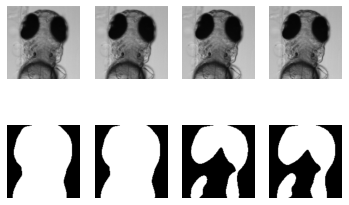

In [17]:
#  sanity check for the mask and images

startNum = 150
n_samples = 4

for i in range(n_samples):
    plt.subplot(2, n_samples, 1+i)
    plt.axis('off')
    plt.imshow(X_patches[int(i+startNum)], cmap='gray')
    
for i in range(n_samples):
    plt.subplot(2, n_samples, 1+n_samples+i)
    plt.axis('off')
    plt.imshow(Y_masks[int(i+startNum)], cmap='gray')    
plt.show()


#### prepare the models

In [20]:
# usinng pre-trained weight

import tensorflow
import tensorflow.keras

import segmentation_models as sm

# from keras_applications.resnet import ResNetV2

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

Segmentation Models: using `keras` framework.


In [21]:
# preprocessing the data

# preprocess input
images = X_patches; masks = Y_masks;
images = preprocess_input(images)
# print(images1.shape)  # come with packed toolset

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size = 0.25, random_state = 42)


In [22]:
print('training data:', X_train.shape, Y_train.shape)
print('validation data:', X_val.shape, Y_val.shape )

training data: (187, 256, 256, 3) (187, 256, 256, 1)
validation data: (63, 256, 256, 3) (63, 256, 256, 1)


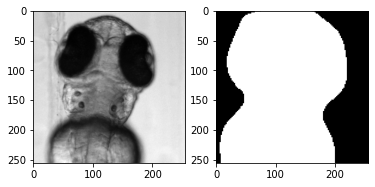

In [23]:
#Sanity check for training dataset. view few mages

import random
import numpy as np
image_number = random.randint(0, len(X_train))

subShow(X_train[image_number, :,:, 0], Y_train[image_number])

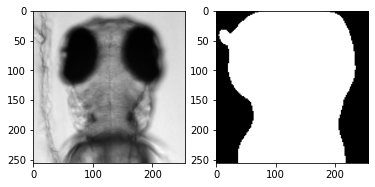

In [24]:
#Sanity check for validation dataset, view few mages

image_number = random.randint(0, len(X_val))

subShow(X_val[image_number, :,:, 0], Y_val[image_number])


In [25]:
# data generator

seed=24
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# add data augmentaton strategy
img_data_gen_args = dict(rotation_range=90,
#                      width_shift_range=0.3,
#                      height_shift_range=0.3,
#                      shear_range=0.5,
#                      zoom_range=0.3,
#                      horizontal_flip=True,
#                      vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
#                      width_shift_range=0.3,
#                      height_shift_range=0.3,
#                      shear_range=0.5,
#                      zoom_range=0.3,
#                      horizontal_flip=True,
#                      vertical_flip=True,
                     fill_mode='reflect',)
                     #preprocessing_function = lambda x: np.where(x>0.1, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)  # relevant to normalization

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_val, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(Y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(Y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(Y_val, seed=seed)

In [26]:
# pack the two generators together

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

In [27]:
# generator pack for later use
my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

x = image_generator.next()
y = mask_generator.next()

In [28]:
# # sanity check in the generator size in range

# for i in range(28,31):
#     image = x[i]
#     print(np.min(mask))
#     plt.subplot(1,2,1)
#     plt.imshow(image[:,:,0], cmap='gray')
#     plt.subplot(1,2,2)
#     plt.imshow(mask[:,:,0], cmap='gray')
#     plt.show()

In [29]:
# define model

import segmentation_models as sm

sm.set_framework('tf.keras')  # ！ this serves for the sm.Unet
sm.framework()

model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])  # bce is differentiable
# print(model.summary())

2022-06-07 17:05:26.033592: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30212 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


In [30]:
import tensorflow.keras as k

if DOCUMENT:
    callbacks = [
        k.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
        neptune_cbk, 
        k.callbacks.TensorBoard(log_dir = './Unet/tensorBoard')  # save in new folder in hemera. Also update in neptune
    ]
else:
    callbacks = [
        k.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
        k.callbacks.TensorBoard(log_dir = './Unet/tensorBoard')  # save in new folder in hemera. Also update in neptune
    ]

2022-06-07 17:05:27.763841: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-06-07 17:05:27.763942: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-06-07 17:05:27.814269: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-06-07 17:05:27.816441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /trinity/shared/pkg/devel/julia/1.7.2/lib:/trinity/shared/pkg/analysis/root/6.26.02/lib:/trinity/shared/pkg/analysis/root/6.26.02/lib/root:/trinity/shared/pkg/analysis/octave/5.1.0/lib:/trinity/shared/pkg/numlib/fftw/3.3.8/gcc/7.3.0/lib:/trinity/shared/pkg/numlib/lapack/3.8.0/gcc/7.3.0/lib64:/trinity/shared/pkg/devel/cuda/11.2/lib64:/trinity/shared/pkg/devel/cuda/11.2/lib:/trinity/shared/pkg/numlib/mpfr/3.1.4/lib:

In [ ]:
#Fit the model and train

# history = model.fit_generator(my_generator, validation_data=validation_datagen, steps_per_epoch=2, validation_steps=2, epochs=1, callbacks = callbacks)

history = model.fit_generator(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=TRAIN, callbacks = callbacks)

/home/li52/.conda/envs/LM/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/li52/.conda/envs/LM/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-06-07 17:05:28.823510: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300


2022-06-07 17:05:35.037785: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


 2/50 [>.............................] - ETA: 14s - loss: 1.3983 - iou_score: 0.3776  

2022-06-07 17:05:47.501072: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-06-07 17:05:47.501110: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-06-07 17:05:47.501233: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2022-06-07 17:05:47.671194: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-07 17:05:47.671502: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2022-06-07 17:05:47.691975: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-06-07 17:05:47.697105: I tensorflow

50/50 [==============================] - 87s 1s/step - loss: 0.4856 - iou_score: 0.7797 - val_loss: 2.7538 - val_iou_score: 0.6035
Epoch 2/300
50/50 [==============================] - 66s 1s/step - loss: 0.3410 - iou_score: 0.8608 - val_loss: 2.9338 - val_iou_score: 0.0570
Epoch 3/300
50/50 [==============================] - 49s 998ms/step - loss: 0.3104 - iou_score: 0.8709 - val_loss: 2.7582 - val_iou_score: 0.0609
Epoch 4/300
50/50 [==============================] - 49s 1s/step - loss: 0.3309 - iou_score: 0.8669 - val_loss: 5.7819 - val_iou_score: 0.0013
Epoch 5/300
50/50 [==============================] - 66s 1s/step - loss: 0.3202 - iou_score: 0.8705 - val_loss: 4.8637 - val_iou_score: 0.0025
Epoch 6/300
50/50 [==============================] - 49s 1s/step - loss: 0.2915 - iou_score: 0.8795 - val_loss: 2.1963 - val_iou_score: 0.1169
Epoch 7/300
50/50 [==============================] - 49s 996ms/step - loss: 0.2778 - iou_score: 0.8831 - val_loss: 4.4101 - val_iou_score: 0.0044
Epoch

In [ ]:
# del images, masks, X_train, X_val, Y_train, Y_val

In [ ]:
# training visualization

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# iou
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# save model as local

model.save("./Unet/model/Unet2D_transfer_noAug_pad.h5")

#### test the images

In [ ]:
# # running test directly from loading the model

# from patchify import patchify, unpatchify

# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import ndimage
# import os
# import pandas as pd
# import random


# import tensorflow
# import tensorflow.keras

# import segmentation_models as sm


# # loading model from local way
# from keras.models import load_model

# model = load_model("./Unet/model/Unet2D_transfer_noAug_pad.h5", compile=False)  # some self-defined loss should be loaded by segmentation_models

# # from keras_applications.resnet import ResNetV2

# BACKBONE = 'resnet34'
# preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# prepare the test datasset for the rest of the images

testIMG = IMG[numIMG:totalIMG,...]
testMask = Mask[numIMG:totalIMG,...]

testIMG = testIMG[...,:testIMG.shape[1]]  # crop for later scaling
testMask = testMask[...,:testMask.shape[1]]

print(testIMG.shape)


In [ ]:
# pre-process the dataset

X_test = resize(testIMG, (totalIMG - numIMG,SIZE[0],SIZE[1]), anti_aliasing=True)  # resize the images
X_test = np.interp(X_test, (X_test.min(), X_test.max()), (0, 1))

Y_test = resize(testMask.astype(bool), (totalIMG - numIMG,SIZE[0],SIZE[1]), anti_aliasing=False)
Y_test = Y_test.astype(int)

print('before:',testIMG.shape)
print('after:',X_test.shape)

In [ ]:
# check the data range for contrast

print('img range:', np.max(X_test), np.min(X_test))
print('mask range:', np.max(Y_test), np.min(Y_test))


In [ ]:
# preprocess the images

patchPara = {'x': 256, 'y': 256, 'step':256}

X_test, _ =  rawPatch(X_test, patchPara); X_test = np.stack((X_test,)*3, axis=-1)
Y_test, _ = rawPatch(Y_test, patchPara); Y_test = np.expand_dims(Y_test, -1)

print('test image shape:', X_test.shape, X_test.dtype)
print('test image shape:', Y_test.shape, Y_test.dtype)

In [ ]:
# # prepare the test dataset. bigger pic

# NUM1 = 51
# NUM2 = 65

# testIMG = resize(IMG[NUM1:NUM2,...], (NUM2-NUM1,SIZE[0],SIZE[1]), anti_aliasing=True) # only takes 5 images from the raw databank
# testMask = resize(Mask[NUM1:NUM2,...], (NUM2-NUM1,SIZE[0],SIZE[1]), anti_aliasing=True)

# unpatchPara = testIMG[0].shape

# # test on bigger image. only for the bigger image

# from patchify import patchify, unpatchify

# imagePred = []

# for i in range(testIMG.shape[0]):
#     tIMG = np.expand_dims(testIMG[i,...], axis=0)
#     tPatch, _ = rawPatch(tIMG, patchPara)
#     tPatch = np.stack((tPatch,)*3, axis=-1)
#     tPatch = preprocess_input(tPatch)
#     tPred = model.predict(tPatch)
#     imgPred = np.reshape(tPred[...,0], (4, 5, 256, 256))
#     imgPred = unpatchify(imgPred, unpatchPara)
#     bar = np.ones((imgPred.shape[0], 15))   # lines
#     combTemp = np.concatenate((testIMG[i,...], bar, imgPred, bar, testMask[i,...]), axis=1)
    
#     if DOCUMENT:
#         # upload the test results into neptune with handle 'description'
#         run["test/sample_images"].log(neptune.types.File.as_image(combTemp), name=str(i), description='test images')  
    
#     # upload the test images to neptune
    
    
    
#     imagePred.append(imgPred)
    
# imagePred = np.asarray(imagePred)

In [ ]:
# prediction 

X_test = preprocess_input(X_test)

imgPred = model.predict(X_test)

# print(imgPred.shape, Y_test.shape, X_test.shape)

In [ ]:
# sanity check 

NUM = 16

subShow(imgPred[NUM,...], Y_test[NUM,...])  # they are binary value

In [ ]:
print(np.max(imgPred[NUM,...]), np.max(Y_test[NUM,...]))

In [ ]:
# # without docuent

# imagePred = []

# for i in range(imgPred.shape[0]):
#     tIMG = X_test[i,...][...,0]  # input
#     tPred = imgPred[i,...] # prediction
#     tMask = Y_test[i,...] # GT
    
#     bar = np.ones((tIMG.shape[0], 15))   # lines
#     combTemp = np.concatenate((tIMG, bar, np.squeeze(tPred), bar, np.squeeze(tMask)), axis=1)
    
#     imagePred.append(combTemp)
    
# imagePred = np.asarray(imagePred)

# # sanity check for one image
# test = np.asarray(imagePred)
# plt.imshow(test[0,...], cmap='gray')

In [ ]:
# document with neptune

imagePred = []

for i in range(imgPred.shape[0]):
    tIMG = X_test[i,...][...,0]  # input
    tPred = imgPred[i,...] # prediction
    tMask = Y_test[i,...] # GT
    
    bar = np.ones((tIMG.shape[0], 15))   # lines
    combTemp = np.concatenate((tIMG, bar, np.squeeze(tPred), bar, np.squeeze(tMask)), axis=1)
    
    
    # upload the test images to neptune
    if DOCUMENT:
        # upload the test results into neptune with handle 'description'
        run["test/sample_images"].log(neptune.types.File.as_image(combTemp), name=str(i), description='test images')  
    
    imagePred.append(combTemp)
    
imagePred = np.asarray(imagePred)

In [ ]:
# sanity check

print(imagePred.shape)
plt.imshow(imagePred[1,...], cmap='gray')

print(np.max(imagePred), np.min(imagePred))

In [ ]:
# # resume to logging more data
# import neptune.new as neptune

# run = neptune.init(
#     project='leeleeroy/LM-2D-Unet',
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
#     run="LMDUN-20",  
# )  # necessary credentials, the name could be used to reproduce the results 

# neptune.create_experiment(upload_source_files=['Unet_transfer.ipynb'])

In [ ]:
# stop the neptune
if DOCUMENT:
    run.stop() 

In [ ]:
# run.stop()